# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 25.09.2022

Мягкий дедлайн: 23:59MSK 10.10.2022

Жесткий дедлайн: 23:59MSK 18.10.2022

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [ ]:
#!pip install folium

In [1]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
%matplotlib inline

sns.set(style="darkgrid")

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [3]:
data_path = "../datasets/taxi_trip_duration.csv"
df_origin = pd.read_csv(data_path)
df = df_origin.copy()
df.shape

(1458644, 11)

In [4]:
df.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [5]:
df.drop(columns=["dropoff_datetime"], inplace=True)

In [6]:
df["pickup_datetime"] = pd.to_datetime(df['pickup_datetime'])
df.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
dtype: object

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

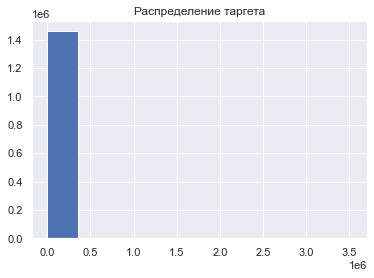

In [7]:
plt.hist(df.trip_duration)
plt.title("Распределение таргета")
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: :・ﾟ

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

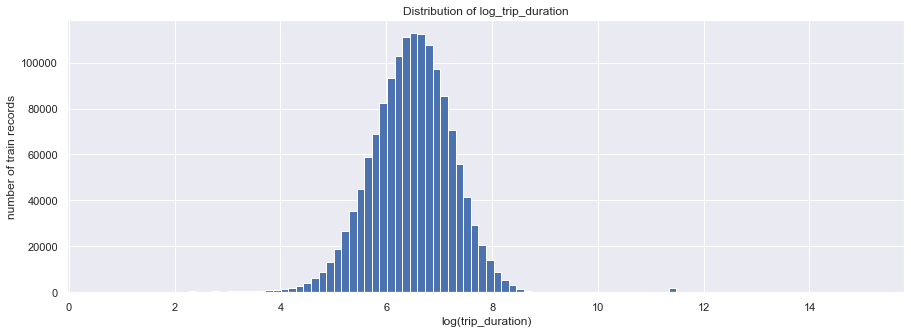

In [7]:
df['log_trip_duration'] = np.log1p(df['trip_duration'].values)

plt.figure(figsize=(15, 5))
plt.hist(df['log_trip_duration'].values, bins=100)
plt.title("Distribution of log_trip_duration")
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [8]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

In [9]:
best_const_predict = df_train.log_trip_duration.mean()

const_metric_train = mean_squared_error(df_train.log_trip_duration.values, 
                                        best_const_predict*np.ones(df_train.shape[0]))

const_metric_test = mean_squared_error(df_test.log_trip_duration.values, 
                                       best_const_predict*np.ones(df_test.shape[0]))


print(f"Metric for best constant solution on train: {const_metric_train:.3f}")
print(f"Metric for best constant solution on test : {const_metric_test:.3f}")

Metric for best constant solution on train: 0.634
Metric for best constant solution on test : 0.632


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

<AxesSubplot:xlabel='count', ylabel='pickup_day'>

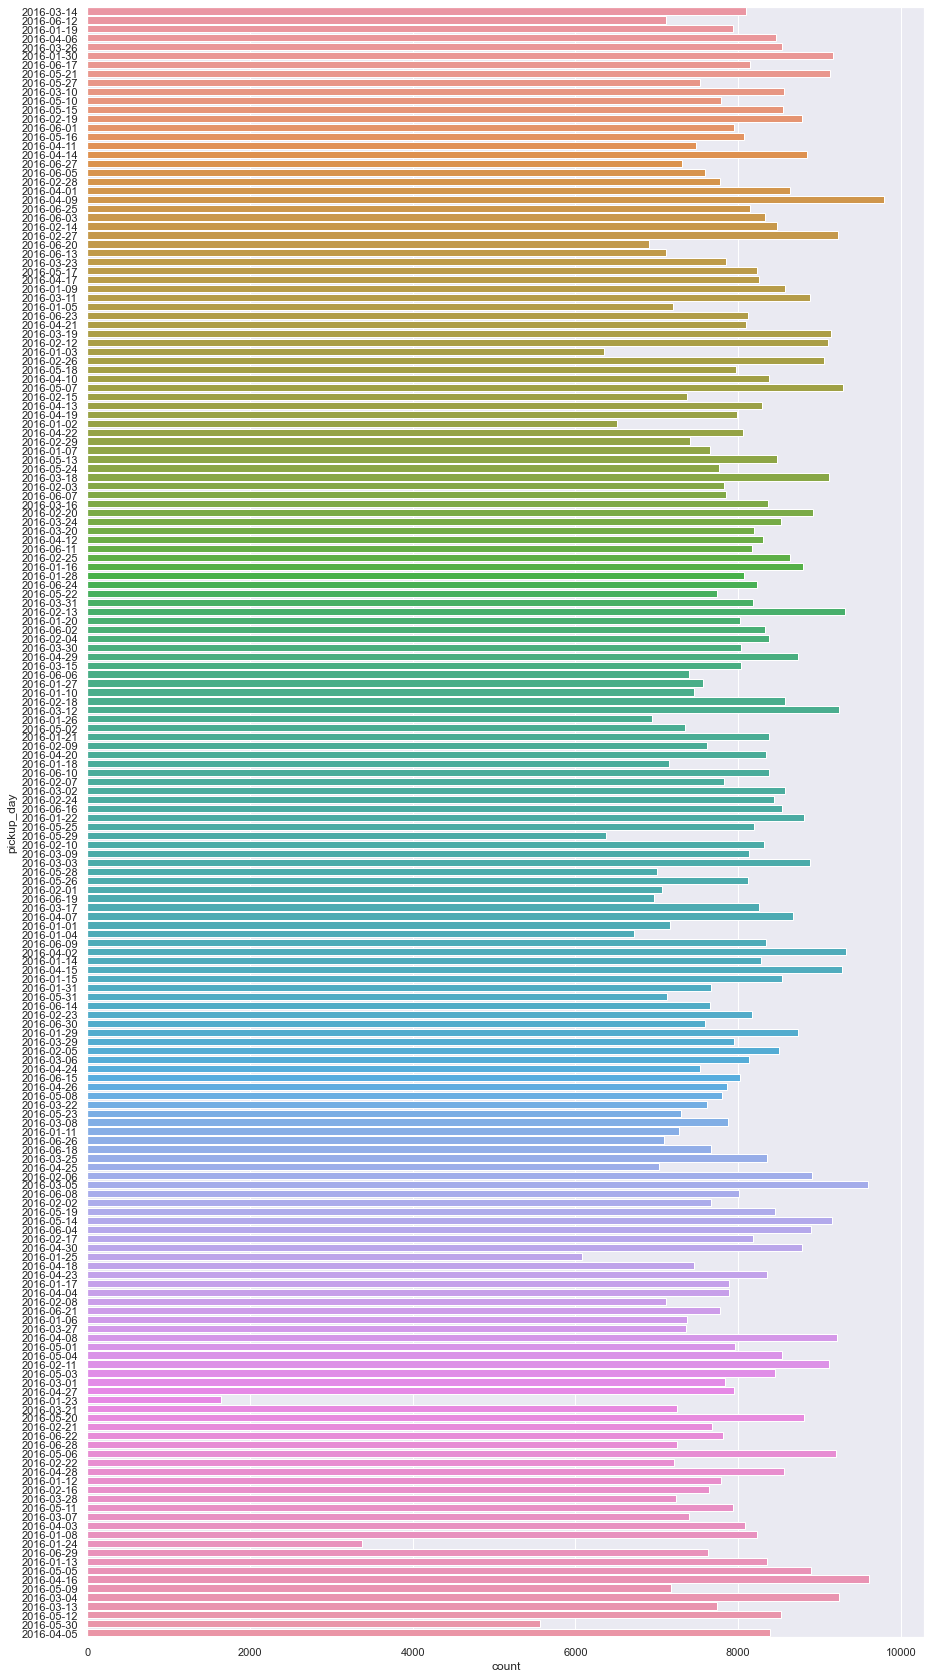

In [10]:
df['pickup_day'] = df.pickup_datetime.dt.date
plt.figure(figsize=(15, 30))
sns.countplot(y="pickup_day", data=df)

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

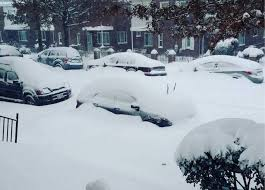

In [11]:
df['weekday'] = df['pickup_datetime'].dt.weekday
df['hour'] = df['pickup_datetime'].dt.hour

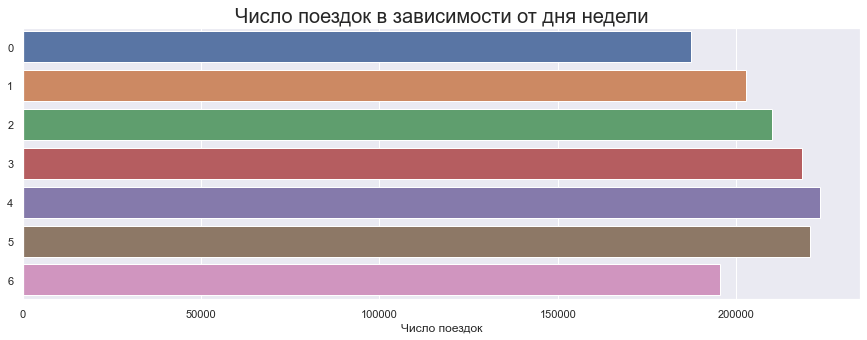

In [12]:
sns.set()

fig, ax = plt.subplots(figsize=(15, 5))

ax = sns.countplot(y="weekday", data=df)

ax.set_title('Число поездок в зависимости от дня недели', size=20)
ax.set_ylabel('')
ax.set(xlabel='Число поездок')
plt.show()

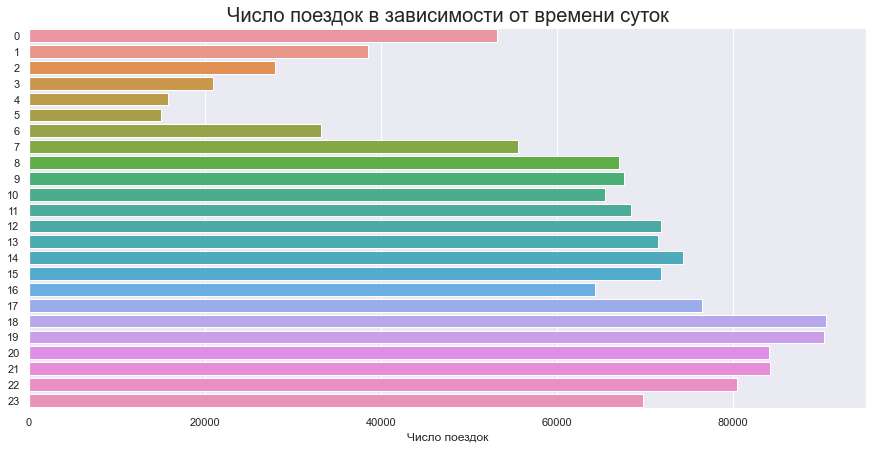

In [13]:
sns.set()

fig, ax = plt.subplots(figsize=(15, 7))

ax = sns.countplot(y="hour", data=df)

ax.set_title('Число поездок в зависимости от времени суток', size=20)
ax.set_ylabel('')
ax.set(xlabel='Число поездок')
plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

In [12]:
df['month'] = df['pickup_datetime'].dt.month
df.head(3)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_day,weekday,hour,month
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493,2016-03-14,0,17,3
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282,2016-06-12,6,0,6
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527,2016-01-19,1,11,1


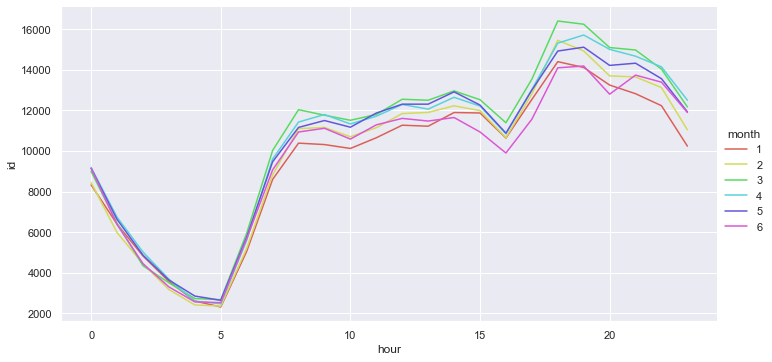

In [15]:
sns.relplot(data=df.groupby(["month", "hour"], as_index=False).count(), 
            x = 'hour',  
            y="id", 
            hue="month",
            kind="line",
            palette=sns.color_palette("hls", 6),
            aspect=2);

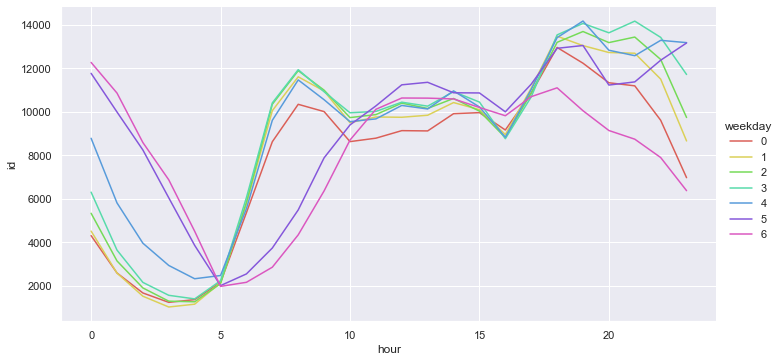

In [16]:
sns.relplot(data=df.groupby(["weekday", "hour"], as_index=False).count(), 
            x = 'hour',  
            y="id", 
            hue="weekday",
            kind="line",
            palette=sns.color_palette("hls", 7),
            aspect=2);

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [13]:
df_train, df_test = train_test_split(df, train_size=0.7)

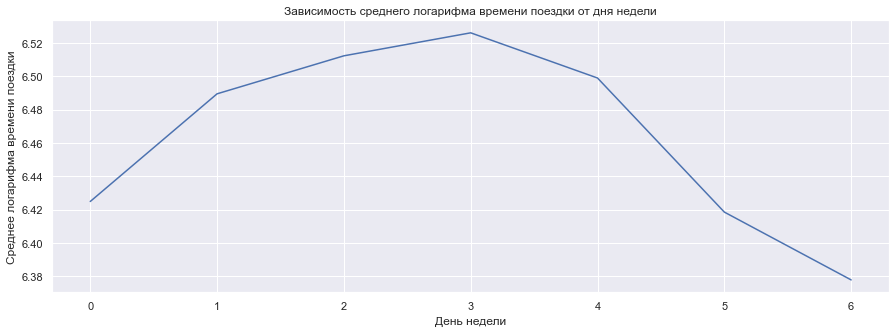

In [18]:
plt.figure(figsize=(15, 5))
plt.title("Зависимость среднего логарифма времени поездки от дня недели")
plt.plot(df_train.groupby(['weekday'])["log_trip_duration"].agg("mean"))
plt.xlabel("День недели")
plt.ylabel("Среднее логарифма времени поездки")
plt.show()

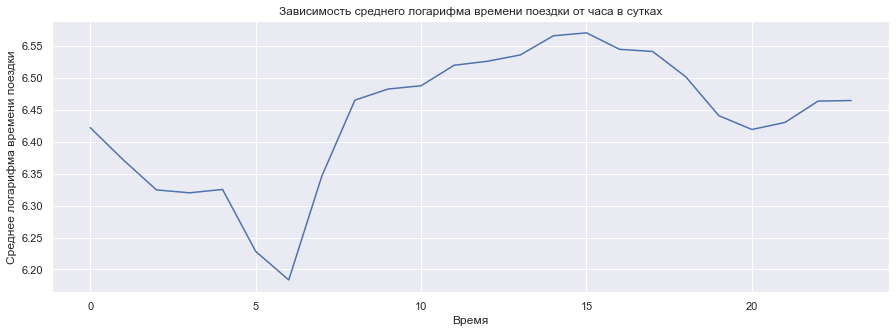

In [19]:
plt.figure(figsize=(15, 5))
plt.title("Зависимость среднего логарифма времени поездки от часа в сутках")
plt.plot(df_train.groupby(['hour'])["log_trip_duration"].agg("mean"))
plt.xlabel("Время")
plt.ylabel("Среднее логарифма времени поездки")
plt.show()

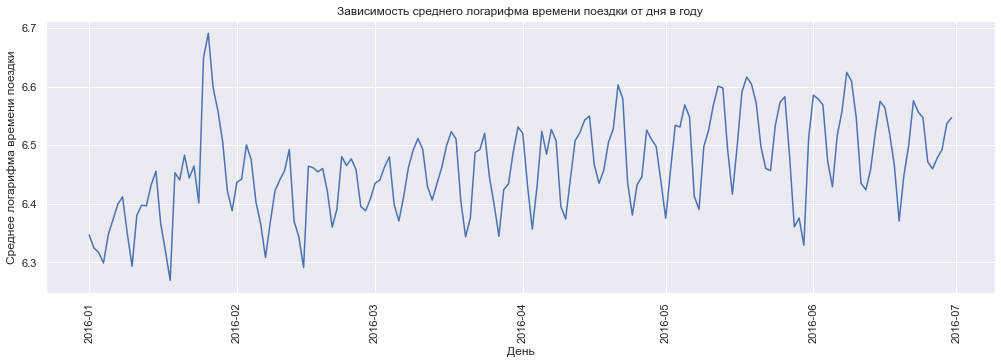

In [20]:
plt.figure(figsize=(17, 5))
plt.title("Зависимость среднего логарифма времени поездки от дня в году")
plt.plot(df_train.groupby(['pickup_day'])["log_trip_duration"].agg("mean"))
plt.xlabel("День")
plt.xticks(rotation = 90)
plt.ylabel("Среднее логарифма времени поездки")
plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [18]:
df_test.loc[:, "pickup_datetime"]

318724    2016-02-17 23:41:14
720712    2016-04-08 18:30:53
805703    2016-03-29 17:54:43
712603    2016-06-21 11:01:59
1233295   2016-01-28 20:44:58
                  ...        
368682    2016-06-13 09:30:21
423747    2016-05-14 16:25:18
1151315   2016-06-15 06:52:39
913700    2016-04-04 18:36:13
1033404   2016-04-06 18:41:26
Name: pickup_datetime, Length: 437594, dtype: datetime64[ns]

In [20]:
df_train['day_year'] = df_train["pickup_datetime"].dt.dayofyear
df_test['day_year'] = df_test["pickup_datetime"].dt.dayofyear
df_train.head(3)

<ipython-input-20-17f58a956e1c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['day_year'] = df_train["pickup_datetime"].dt.dayofyear
<ipython-input-20-17f58a956e1c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['day_year'] = df_test["pickup_datetime"].dt.dayofyear


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_day,weekday,hour,month,day_year
228910,id0789871,1,2016-03-19 21:06:23,1,-73.957977,40.778835,-73.991295,40.750038,N,883,6.784457,2016-03-19,5,21,3,79
657889,id0777102,2,2016-05-11 14:36:34,1,-73.977974,40.734261,-73.992561,40.750900,N,1741,7.462789,2016-05-11,2,14,5,132
122376,id0610944,2,2016-05-18 06:55:36,6,-73.982147,40.731842,-73.976761,40.739307,N,114,4.744932,2016-05-18,2,6,5,139


In [21]:
import datetime
anom_date_train = (df_train['pickup_day'] == datetime.date(2016, 1, 23)) | (df_train['pickup_day'] == datetime.date(2016, 1, 24))
df_train['anomal_date'] = anom_date_train.astype(int)
df_train.head(3)

<ipython-input-21-0cc90fee33af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['anomal_date'] = anom_date_train.astype(int)


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_day,weekday,hour,month,day_year,anomal_date
228910,id0789871,1,2016-03-19 21:06:23,1,-73.957977,40.778835,-73.991295,40.750038,N,883,6.784457,2016-03-19,5,21,3,79,0
657889,id0777102,2,2016-05-11 14:36:34,1,-73.977974,40.734261,-73.992561,40.750900,N,1741,7.462789,2016-05-11,2,14,5,132,0
122376,id0610944,2,2016-05-18 06:55:36,6,-73.982147,40.731842,-73.976761,40.739307,N,114,4.744932,2016-05-18,2,6,5,139,0


In [22]:
anom_date_test = (df_test['pickup_day'] == datetime.date(2016, 1, 23)) | (df_test['pickup_day'] == datetime.date(2016, 1, 24))
df_test['anomal_date'] = anom_date_test.astype(int)

<ipython-input-22-56b81d6f56a6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['anomal_date'] = anom_date_test.astype(int)


Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

In [23]:
cat_features = ["passenger_count", 
                "store_and_fwd_flag",
                "weekday",
                "hour",
                "month",
                "day_year",
                "anomal_date"]

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [24]:
ohe = OneHotEncoder(handle_unknown = "ignore")

X_train = df_train[cat_features].values
X_test = df_test[cat_features].values
y_train = df_train.log_trip_duration.values
y_test = df_test.log_trip_duration.values

train_feats = ohe.fit_transform(X_train)
test_feats = ohe.transform(X_test)

print(train_feats.shape, test_feats.shape)

(1021050, 232) (437594, 232)


In [26]:
ridge = Ridge()
ridge.fit(train_feats, y_train)
y_pred_train = ridge.predict(train_feats)
y_pred_test= ridge.predict(test_feats)

In [27]:
ridge_train_metric = mean_squared_error(y_train, y_pred_train)
ridge_test_metric = mean_squared_error(y_test, y_pred_test)

In [28]:
print(f"mean_squared_error for the:")

print(f" \t\t\t\t best const solution on train: {const_metric_train:.4f}")
print(f" \t\t\t\t best const solution on test: {const_metric_test:.4f}")

print(f" \t\t\t\t ridge model on train: {ridge_train_metric:.4f}")
print(f" \t\t\t\t ridge model on test: {ridge_test_metric:.4f}")

mean_squared_error for the:
 				 best const solution on train: 0.6337
 				 best const solution on test: 0.6321
 				 ridge model on train: 0.6187
 				 ridge model on test: 0.6203


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [29]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [30]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [31]:
show_circles_on_map(df.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?
 - John F. Kennedy International Airport
 - LaGuardia Airport

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [30]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

df_train['manhattan_dist'] = dummy_manhattan_distance(df_train['pickup_latitude'].values,
                                                      df_train['pickup_longitude'].values,
                                                      df_train['dropoff_latitude'].values,
                                                      df_train['dropoff_longitude'].values)

df_test['manhattan_dist'] = dummy_manhattan_distance(df_test['pickup_latitude'].values,
                                                      df_test['pickup_longitude'].values,
                                                      df_test['dropoff_latitude'].values,
                                                      df_test['dropoff_longitude'].values)

<ipython-input-30-7a9983598554>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['manhattan_dist'] = dummy_manhattan_distance(df_train['pickup_latitude'].values,
<ipython-input-30-7a9983598554>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['manhattan_dist'] = dummy_manhattan_distance(df_test['pickup_latitude'].values,


In [31]:
df_train.head(2)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_day,weekday,hour,month,day_year,anomal_date,manhattan_dist
228910,id0789871,1,2016-03-19 21:06:23,1,-73.957977,40.778835,-73.991295,40.750038,N,883,6.784457,2016-03-19,5,21,3,79,0,6.007464
657889,id0777102,2,2016-05-11 14:36:34,1,-73.977974,40.734261,-73.992561,40.750900,N,1741,7.462789,2016-05-11,2,14,5,132,0,3.079347


Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [32]:
df_train['log_manhattan_dist'] = np.log1p(df_train['manhattan_dist'].values)
df_test['log_manhattan_dist'] = np.log1p(df_test['manhattan_dist'].values)

<ipython-input-32-33096613cd75>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['log_manhattan_dist'] = np.log1p(df_train['manhattan_dist'].values)
<ipython-input-32-33096613cd75>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['log_manhattan_dist'] = np.log1p(df_test['manhattan_dist'].values)


In [33]:
df_train.head(3)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_day,weekday,hour,month,day_year,anomal_date,manhattan_dist,log_manhattan_dist
228910,id0789871,1,2016-03-19 21:06:23,1,-73.957977,40.778835,-73.991295,40.750038,N,883,6.784457,2016-03-19,5,21,3,79,0,6.007464,1.946976
657889,id0777102,2,2016-05-11 14:36:34,1,-73.977974,40.734261,-73.992561,40.750900,N,1741,7.462789,2016-05-11,2,14,5,132,0,3.079347,1.405937
122376,id0610944,2,2016-05-18 06:55:36,6,-73.982147,40.731842,-73.976761,40.739307,N,114,4.744932,2016-05-18,2,6,5,139,0,1.283967,0.825914


Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

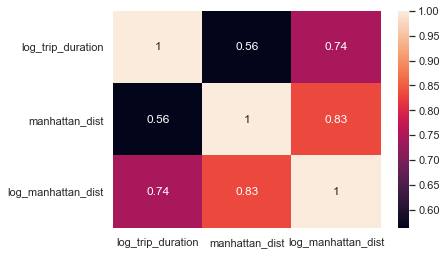

In [34]:
corr = df_train[["log_trip_duration", "manhattan_dist", "log_manhattan_dist"]].corr()
sns.heatmap(corr, annot=True);

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [35]:
df_train.loc[:, "mean_velocity"] = df_train['manhattan_dist'].values*3600 / df_train['trip_duration'].values
df_test.loc[:, "mean_velocity"] = df_test['manhattan_dist'].values*3600 / df_test['trip_duration'].values

C:\Users\asus\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\asus\anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [36]:
df_test.head(3)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_day,weekday,hour,month,day_year,anomal_date,manhattan_dist,log_manhattan_dist,mean_velocity
318724,id2591362,2,2016-02-17 23:41:14,1,-73.983749,40.765450,-73.980759,40.787685,N,501,6.218600,2016-02-17,2,23,2,48,0,2.724388,1.314903,19.576441
720712,id1842064,2,2016-04-08 18:30:53,1,-73.974098,40.788841,-73.976242,40.780891,N,284,5.652489,2016-04-08,4,18,4,99,0,1.064468,0.724873,13.493260
805703,id2127199,1,2016-03-29 17:54:43,1,-73.991966,40.666351,-73.976425,40.682304,N,440,6.089045,2016-03-29,1,17,3,89,0,3.084685,1.407245,25.238331


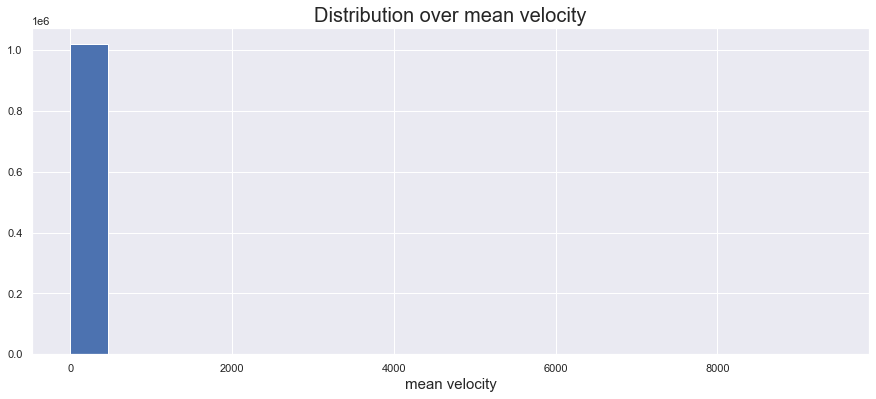

In [39]:
plt.figure(figsize = (15, 6))
plt.hist(df_train.mean_velocity.values, bins=20)
plt.xlabel("mean velocity", size = 15)
plt.title("Distribution over mean velocity", size = 20)
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

In [37]:
max_velocity = np.quantile(df_train.mean_velocity.values, 0.99)
max_velocity

54.84637919760357

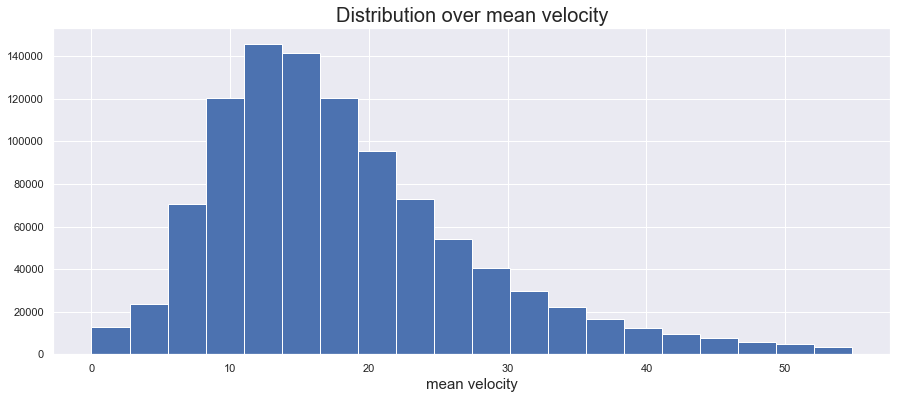

In [38]:
plt.figure(figsize = (15, 6))
plt.hist(df_train[df_train.mean_velocity<max_velocity].mean_velocity.values, bins=20)
plt.xlabel("mean velocity", size = 15)
plt.title("Distribution over mean velocity", size = 20)
plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [39]:
weekday_velocity = df_train.groupby(['weekday', "hour"], as_index = False).agg({"mean_velocity": "median"}) \
                .rename(columns = {"hour": "hour", "weekday": "weekday", "mean_velocity": "velocity_median"})
weekday_velocity

,weekday,hour,velocity_median
0,0,0,25.558958
1,0,1,25.647005
2,0,2,25.920987
3,0,3,25.884820
4,0,4,30.670408
...,...,...,...
163,6,19,17.930911
164,6,20,19.483676
165,6,21,20.768067
166,6,22,21.965342


In [40]:
day_hour_matrix = np.zeros(shape = (7, 24))
for _, row in weekday_velocity.iterrows():
    day_hour_matrix[int(row["weekday"]), int(row["hour"])] = row["velocity_median"]

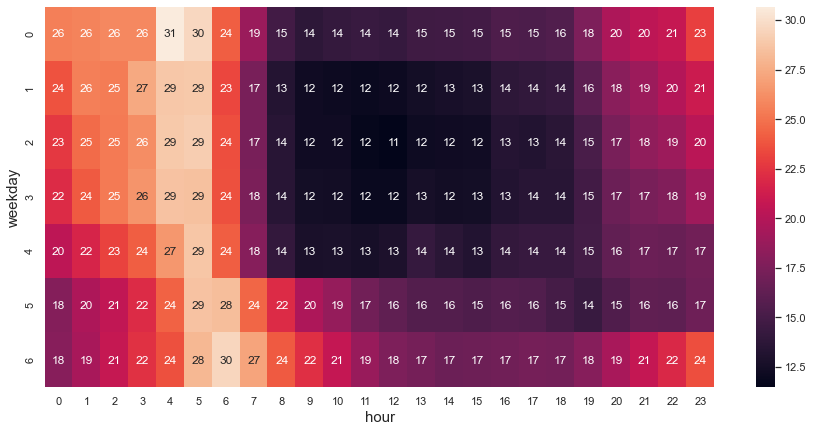

In [41]:
plt.figure(figsize = (15, 7))
sns.heatmap(day_hour_matrix, annot=True)
plt.xlabel('hour', size = 15)
plt.ylabel('weekday', size = 15)
plt.show()

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

In [42]:
for df_ in (df_train, df_test):
    df_.drop(columns = ['mean_velocity'], inplace = True)

C:\Users\asus\anaconda3\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [43]:
df_test.head(2)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_day,weekday,hour,month,day_year,anomal_date,manhattan_dist,log_manhattan_dist
318724,id2591362,2,2016-02-17 23:41:14,1,-73.983749,40.765450,-73.980759,40.787685,N,501,6.218600,2016-02-17,2,23,2,48,0,2.724388,1.314903
720712,id1842064,2,2016-04-08 18:30:53,1,-73.974098,40.788841,-73.976242,40.780891,N,284,5.652489,2016-04-08,4,18,4,99,0,1.064468,0.724873


**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [44]:
traffic_jams_train_1 = (df_train['weekday'] <= 5) & (df_train['hour'] >= 7)  & (df_train['hour'] <= 19)
traffic_jams_train_2 = (df_train['weekday'] >= 5) & (df_train['hour'] >= 11)  & (df_train['hour'] <= 19)
traffic_jams_train_3 = (df_train['weekday'] <= 5) & (df_train['weekday'] >= 4)  & (df_train['hour'] > 19)
df_train['traffic_jam'] = (traffic_jams_train_1 | traffic_jams_train_2 | traffic_jams_train_3).astype(int)

<ipython-input-44-883734129155>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['traffic_jam'] = (traffic_jams_train_1 | traffic_jams_train_2 | traffic_jams_train_3).astype(int)


In [45]:
df_train['traffic_jam'].value_counts()

1    709144
0    311906
Name: traffic_jam, dtype: int64

In [46]:
traffic_jams_test_1 = (df_test['weekday'] <= 5) & (df_test['hour'] >= 7)  & (df_test['hour'] <= 19)
traffic_jams_test_2 = (df_test['weekday'] >= 5) & (df_test['hour'] >= 11)  & (df_test['hour'] <= 19)
traffic_jams_test_3 = (df_test['weekday'] <= 5) & (df_test['weekday'] >= 4)  & (df_test['hour'] > 19)
df_test['traffic_jam'] = (traffic_jams_test_1 | traffic_jams_test_2 | traffic_jams_test_3).astype(int)

<ipython-input-46-2e5a16e008c2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['traffic_jam'] = (traffic_jams_test_1 | traffic_jams_test_2 | traffic_jams_test_3).astype(int)


In [35]:
df_test['traffic_jam'].value_counts()

1    303852
0    133742
Name: traffic_jam, dtype: int64

**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [47]:
Kennedy_Airport_longitude = -73.78413203721722 
Kennedy_Airport_latitude = 40.6507199373132

LaGuardia_longitude = -73.87391943305535 
LaGuardia_latitude =  40.77712882124095

In [48]:
close_kenedy_airport = np.isclose(Kennedy_Airport_longitude, df_train['pickup_longitude'], atol=1e-02)
close_LaGuardia_airport = np.isclose(LaGuardia_latitude, df_train['pickup_latitude'], atol=1e-03)

In [49]:
df_train['close_kenedy_airport'] = close_kenedy_airport.astype(int)
df_train['close_LaGuardia_airport'] = close_LaGuardia_airport.astype(int)

<ipython-input-49-44eb4f05fe2b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['close_kenedy_airport'] = close_kenedy_airport.astype(int)
<ipython-input-49-44eb4f05fe2b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['close_LaGuardia_airport'] = close_LaGuardia_airport.astype(int)


In [50]:
close_kenedy_airport = np.isclose(Kennedy_Airport_longitude, df_test['pickup_longitude'], atol=1e-02)
close_LaGuardia_airport = np.isclose(LaGuardia_latitude, df_test['pickup_latitude'], atol=1e-03)

In [51]:
df_test['close_kenedy_airport'] = close_kenedy_airport.astype(int)
df_test['close_LaGuardia_airport'] = close_LaGuardia_airport.astype(int)

<ipython-input-51-69a01e1dc0f3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['close_kenedy_airport'] = close_kenedy_airport.astype(int)
<ipython-input-51-69a01e1dc0f3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['close_LaGuardia_airport'] = close_LaGuardia_airport.astype(int)


Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

In [52]:
max_duration = df_train['trip_duration'].quantile(q= 0.95)
max_duration

2104.0

Text(0, 0.5, 'trip_duration')

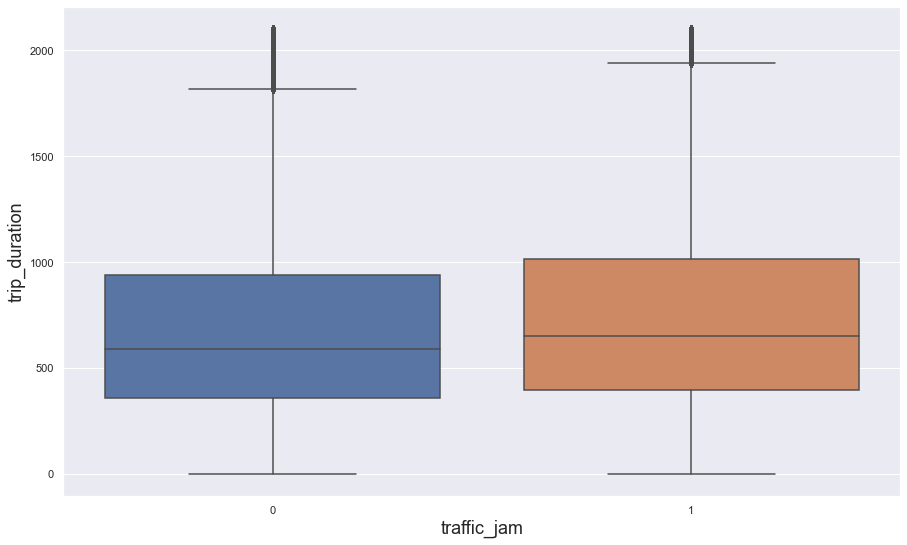

In [57]:
plt.figure(figsize = (15, 9))
sns.boxplot(x = 'traffic_jam', y = "trip_duration", data = df_train[df_train['trip_duration'] < max_duration])
plt.xlabel("traffic_jam", size = 18)
plt.ylabel("trip_duration", size = 18)

Text(0, 0.5, 'trip_duration')

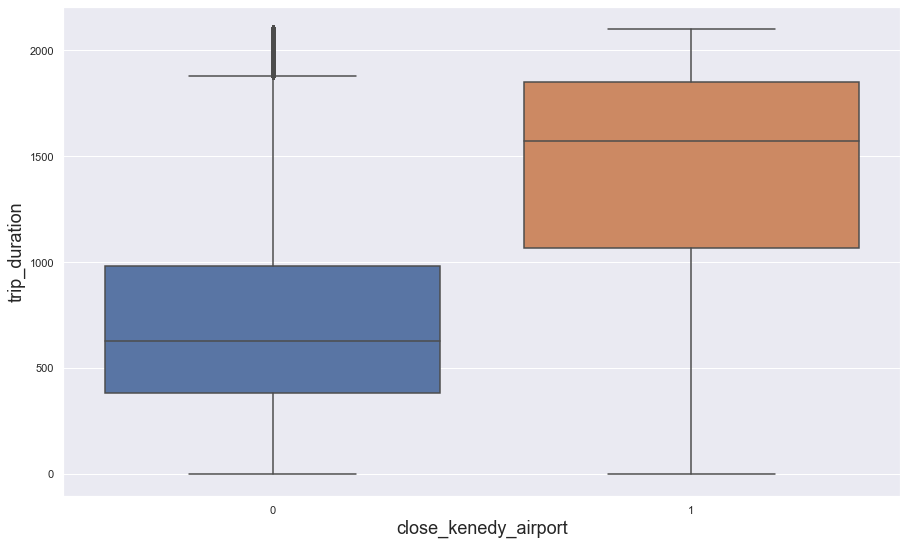

In [58]:
plt.figure(figsize = (15, 9))
sns.boxplot(x = 'close_kenedy_airport', y = "trip_duration", data = df_train[df_train['trip_duration'] < max_duration])
plt.xlabel("close_kenedy_airport", size = 18)
plt.ylabel("trip_duration", size = 18)

Text(0, 0.5, 'trip_duration')

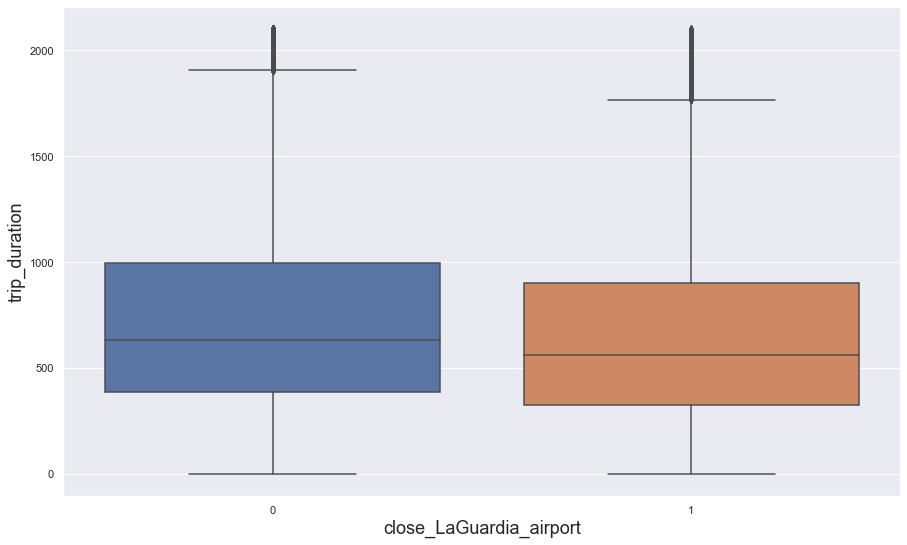

In [59]:
plt.figure(figsize = (15, 9))
sns.boxplot(x = 'close_LaGuardia_airport', y = "trip_duration", data = df_train[df_train['trip_duration'] < max_duration])
plt.xlabel("close_LaGuardia_airport", size = 18)
plt.ylabel("trip_duration", size = 18)

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

In [53]:
df_train.to_csv("../datasets/temp_taxi_train.csv", index = False)
df_train.to_csv("../datasets/temp_taxi_test.csv", index = False)

In [54]:
df_train.head(2)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,weekday,hour,month,day_year,anomal_date,manhattan_dist,log_manhattan_dist,traffic_jam,close_kenedy_airport,close_LaGuardia_airport
228910,id0789871,1,2016-03-19 21:06:23,1,-73.957977,40.778835,-73.991295,40.750038,N,883,...,5,21,3,79,0,6.007464,1.946976,1,0,0
657889,id0777102,2,2016-05-11 14:36:34,1,-73.977974,40.734261,-73.992561,40.750900,N,1741,...,2,14,5,132,0,3.079347,1.405937,1,0,0


<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [42]:
df_train.head(2)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,weekday,hour,month,day_year,anomal_date,manhattan_dist,log_manhattan_dist,traffic_jam,close_kenedy_airport,close_LaGuardia_airport
1418603,id3394725,2,2016-01-05 17:08:11,1,-73.875893,40.773415,-73.859451,40.838886,N,1805,...,1,17,1,5,0,8.664603,2.268470,1,0,0
975016,id1376394,1,2016-02-19 02:33:10,2,-73.972534,40.765221,-73.930984,40.766960,N,1180,...,4,2,2,50,0,3.692659,1.545999,0,0,0


In [77]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location, zoom_start=11)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [78]:
m = show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")
points = [north_west, north_east, south_east, south_west]
colors = ["red", "green", "orange", 'black']
#m = folium.Map(location=mean_location)
for i, row in enumerate(points):
        folium.Circle(
            radius=200,
            location=(row[0], row[1]),
            color=colors[i],
            fill_color=colors[i],
            fill=True
        ).add_to(m)
points_line = [north_west, north_east, south_east, south_west, north_west]
my_PolyLine=folium.PolyLine(locations=points_line, weight=5, color="red")
m.add_child(my_PolyLine)

my_PolyLine_=folium.PolyLine(locations=vert_lines, weight=1, color="red")
m.add_child(my_PolyLine_)

my_PolyLine_=folium.PolyLine(locations=hor_lines, weight=1, color="red")
m.add_child(my_PolyLine_)

m

In [99]:
from sklearn.base import BaseEstimator, TransformerMixin


# TransformerMixin implements fit_transform for you,
# applying your fit and transform consistently
    
class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_rows=15, n_cols=10):
        # your code here
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.mean_location = None
    
    def show_map(self, 
                 X, 
                 pickup_latitude_column="pickup_latitude",
                 pickup_longitude_column="pickup_longitude",
                 dropoff_latitude_column="dropoff_latitude",
                 dropoff_longitude_column="dropoff_longitude",
                 mode = "pickup"):
        # you may want to visualize cells
        
        if mode == "pickup":
            mean_lat, mean_long = X[pickup_latitude_column].mean(), X[pickup_longitude_column].mean()
        else:
            mean_lat, mean_long = X[dropoff_latitude_column].mean(), X[dropoff_longitude_column].mean()
            
        location = (mean_lat, mean_long)
        m = folium.Map(location=location, zoom_start=11)
        
        points = [self.north_west_point, self.north_east_point, self.south_west_point, self.south_east_point]
        for i, row in enumerate(points):
            folium.Circle(
                radius=200,
                location=(row[0], row[1]),
                color="black",
                fill_color="black",
                fill=True
            ).add_to(m)
        
        vert_lines = []
        hor_lines = []
        
        
        
        for latitude, longitude in zip(self.latitudes_grid, self.longitudes_grid):
            vert_lines.append([[self.south_latitude, longitude], [self.north_latitude, longitude]])
            hor_lines.append([[latitude, self.north_longitude], [latitude, self.south_longitude]])
            
        my_PolyLine_v = folium.PolyLine(locations=vert_lines, weight=1, color="red")
        m.add_child(my_PolyLine_v)

        my_PolyLine_h = folium.PolyLine(locations=hor_lines, weight=1, color="red")
        m.add_child(my_PolyLine_h)
        
        return m

    def fit(self, 
            X=None, 
            y=None, 
            pickup_latitude_column="pickup_latitude",
            pickup_longitude_column="pickup_longitude",
            dropoff_latitude_column="dropoff_latitude",
            dropoff_longitude_column="dropoff_longitude"):
        # your code here
        self.north_latitude, self.north_longitude,  \
        self.south_latitude, self.south_longitude = self.get_max_min_coord(X,
                                                                 pickup_latitude_column,
                                                                 pickup_longitude_column,
                                                                 dropoff_latitude_column,
                                                                 dropoff_longitude_column)
        
        self.north_west_point = (self.north_latitude, self.north_longitude)
        self.north_east_point = (self.north_latitude, self.south_longitude)
        self.south_west_point = (self.south_latitude, self.north_longitude)
        self.south_east_point = (self.south_latitude, self.south_longitude)
        
        #self.latitudes_grid = None
        #self.longitudes_grid = None
        self.latitudes_grid = np.linspace(self.south_latitude, self.north_latitude, self.n_cols)
        self.longitudes_grid = np.linspace(self.north_longitude, self.south_longitude, self.n_rows)
        return self
    
    
    def transform(self, 
                  X, 
                  y=None,
                  pickup_latitude_column="pickup_latitude",
                  pickup_longitude_column="pickup_longitude",
                  dropoff_latitude_column="dropoff_latitude",
                  dropoff_longitude_column="dropoff_longitude"):
        # your code here
        X['pickup_region'] = X[[pickup_latitude_column, pickup_longitude_column]].apply(self.get_rect, axis=1)
        X['dropoff_region'] = X[[dropoff_latitude_column, dropoff_longitude_column]].apply(self.get_rect, axis=1)
        return X
    
    
    def get_max_min_coord(self, 
                          X,    
                          pickup_latitude_column="pickup_latitude",
                          pickup_longitude_column="pickup_longitude",
                          dropoff_latitude_column="dropoff_latitude",
                          dropoff_longitude_column="dropoff_longitude", 
                          q_max=0.975, 
                          q_min=0.025):
        
        north_latitude = max(np.quantile(X[pickup_latitude_column].values, q_max),
                             np.quantile(X[dropoff_latitude_column].values, q_max))
        
        north_longitude = min(np.quantile(X[pickup_longitude_column].values, q_min),
                              np.quantile(X[dropoff_longitude_column].values, q_min))

        south_latitude = min(np.quantile(X[pickup_latitude_column].values, q_min),
                             np.quantile(X[dropoff_latitude_column].values, q_min))
        
        south_longitude = max(np.quantile(X[pickup_longitude_column].values, q_max),
                              np.quantile(X[dropoff_longitude_column].values, q_max))
        
        return north_latitude, north_longitude, south_latitude, south_longitude
    
    
    def get_rect(self, coordinates):
        
        latitude, longitude = coordinates[0], coordinates[1]
        
        i = (latitude >= self.latitudes_grid[:-1]) & (latitude <= self.latitudes_grid[1:])
        if not i.any():
            return -1
        
        j = (longitude >= self.longitudes_grid[:-1]) & (longitude <= self.longitudes_grid[1:]) 
        if not j.any():
            return -1
        
        i, j = np.where(i)[0][0], np.where(j)[0][0]
        return (i+1)*(j+1)
        

In [100]:
grid_transformer = MapGridTransformer(20, 20)
grid_transformer.fit(df_train)

MapGridTransformer(n_cols=20, n_rows=20)

In [101]:
grid_transformer.show_map(df_train)

In [102]:
%%time
df_train = grid_transformer.transform(df_train)

<ipython-input-99-d78f5a0e5189>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['pickup_region'] = X[[pickup_latitude_column, pickup_longitude_column]].apply(self.get_rect, axis=1)


Wall time: 58.2 s


<ipython-input-99-d78f5a0e5189>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dropoff_region'] = X[[dropoff_latitude_column, dropoff_longitude_column]].apply(self.get_rect, axis=1)


<AxesSubplot:>

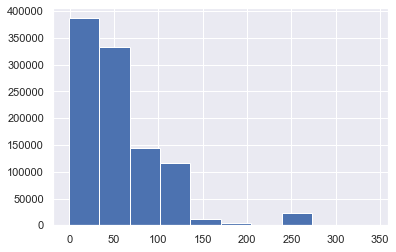

In [104]:
df_train.pickup_region.hist()

In [106]:
%%time
df_test = grid_transformer.transform(df_test)

<ipython-input-99-d78f5a0e5189>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['pickup_region'] = X[[pickup_latitude_column, pickup_longitude_column]].apply(self.get_rect, axis=1)


Wall time: 24.9 s


<ipython-input-99-d78f5a0e5189>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dropoff_region'] = X[[dropoff_latitude_column, dropoff_longitude_column]].apply(self.get_rect, axis=1)


<AxesSubplot:>

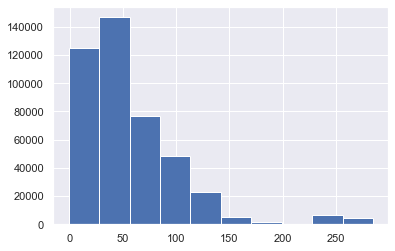

In [107]:
df_test.pickup_region.hist()

In [125]:
pickup_threshold = 500
df_train[df_train["pickup_region"] < pickup_threshold]['pickup_region'] = -1
df_test[df_test["pickup_region"] < pickup_threshold]['pickup_region'] = -1

In [133]:
dropoff_threshold = 500
df_train[df_train["dropoff_region"] < dropoff_threshold]['dropoff_region'] = -1
df_test[df_test["dropoff_region"] < dropoff_threshold]['dropoff_region'] = -1

<AxesSubplot:>

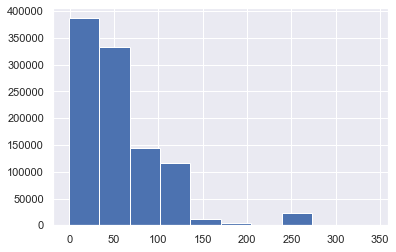

In [134]:
df_train.pickup_region.hist()

<AxesSubplot:>

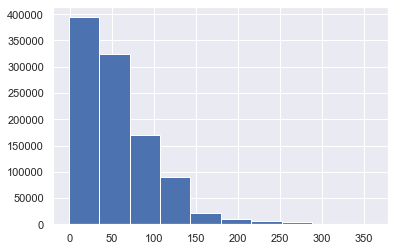

In [135]:
df_train.dropoff_region.hist()

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [137]:
df_train.head(3)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,month,day_year,anomal_date,manhattan_dist,log_manhattan_dist,traffic_jam,close_kenedy_airport,close_LaGuardia_airport,pickup_region,dropoff_region
228910,id0789871,1,2016-03-19 21:06:23,1,-73.957977,40.778835,-73.991295,40.750038,N,883,...,3,79,0,6.007464,1.946976,1,0,0,105,33
657889,id0777102,2,2016-05-11 14:36:34,1,-73.977974,40.734261,-73.992561,40.750900,N,1741,...,5,132,0,3.079347,1.405937,1,0,0,45,33
122376,id0610944,2,2016-05-18 06:55:36,6,-73.982147,40.731842,-73.976761,40.739307,N,114,...,5,139,0,1.283967,0.825914,0,0,0,32,45


In [140]:
df_train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'log_trip_duration', 'pickup_day', 'weekday', 'hour', 'month',
       'day_year', 'anomal_date', 'manhattan_dist', 'log_manhattan_dist',
       'traffic_jam', 'close_kenedy_airport', 'close_LaGuardia_airport',
       'pickup_region', 'dropoff_region'],
      dtype='object')

In [139]:
categorical_features = [
 'passenger_count',
 'store_and_fwd_flag',
 'weekday',
 'hour',
 'month',
 'day_year',
 'anomal_date',
 'traffic_jam',
 'close_kenedy_airport',
 'close_LaGuardia_airport',
 'pickup_region',
 'dropoff_region'   
]
num_features = ['log_manhattan_dist']

In [141]:
ohe = OneHotEncoder(handle_unknown='ignore')
df_train_cat = df_train[categorical_features]
df_test_cat = df_test[categorical_features]
ohe.fit(df_train_cat.values)
X_train_cat = ohe.transform(df_train_cat.values)
X_test_cat = ohe.transform(df_test_cat.values)

In [152]:
X_train_cat.shape, X_test_cat.shape

((1021050, 508), (437594, 508))

In [144]:
sc = StandardScaler()

X_train_num = df_train[num_features]
X_test_num = df_test[num_features]

X_train_sc = sc.fit_transform(X_train_num)
X_test_sc = sc.transform(X_test_num)

In [158]:
X_train_sc.shape, X_train_cat.shape

((1021050, 1), (1021050, 508))

In [162]:
type(X_train_cat.toarray())

numpy.ndarray

In [164]:
X_train = np.concatenate((X_train_cat.toarray(), X_train_sc), axis=1)
X_train.shape

(1021050, 509)

In [165]:
X_test = np.concatenate((X_test_cat.toarray(), X_test_sc), axis=1)
X_test.shape

(437594, 509)

In [166]:
y_train = df_train['log_trip_duration'].values
y_test = df_test['log_trip_duration'].values

In [167]:
lr_ridge = Ridge()
lr_ridge.fit(X_train, y_train)

Ridge()

In [168]:
y_pred_train = lr_ridge.predict(X_train)
y_pred_test = lr_ridge.predict(X_test)

In [178]:
mse_on_train  = mean_squared_error(y_train,y_pred_train)
mse_on_test = mean_squared_error(y_test, y_pred_test)

In [175]:
best_const_predict = df_train.log_trip_duration.mean()

const_metric_train = mean_squared_error(df_train.log_trip_duration.values, 
                                        best_const_predict*np.ones(df_train.shape[0]))

const_metric_test = mean_squared_error(df_test.log_trip_duration.values, 
                                       best_const_predict*np.ones(df_test.shape[0]))

In [180]:
print(f"mean_squared_error for the:")

print(f" \t\t\t\t best const solution on train: {const_metric_train:.4f}")
print(f" \t\t\t\t best const solution on test: {const_metric_test:.4f}")

print(f" \t\t\t\t ridge model on train: {ridge_train_metric:.4f}")
print(f" \t\t\t\t ridge model on test: {ridge_test_metric:.4f}")

print(f" \t\t\t\t ridge model on train after adding new features: {mse_on_train:.4f}")
print(f" \t\t\t\t ridge model on test after adding new features: {mse_on_test:.4f}")

mean_squared_error for the:
 				 best const solution on train: 0.6329
 				 best const solution on test: 0.6340
 				 ridge model on train: 0.6187
 				 ridge model on test: 0.6203
 				 ridge model on train after adding new features: 0.2287
 				 ridge model on test after adding new features: 0.2278


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.